<a href="https://colab.research.google.com/github/daspartho/learn-pytorch/blob/main/paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
import torchvision
import torch

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from modular import data_setup, engine
except:
    print("[INFO] Couldn't find modular scripts... downloading from GitHub.")
    !git clone https://github.com/daspartho/learn-pytorch
    !mv learn-pytorch/modular .
    !rm -rf learn-pytorch
    from modular import data_setup, engine

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [10]:
train_dir = image_path/ "train"
test_dir = image_path/ "test"

In [12]:
IMG_SIZE = 224

transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [13]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transforms,
    BATCH_SIZE,
)

In [15]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

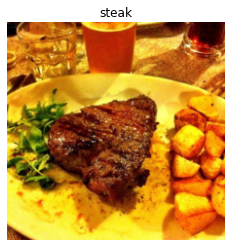

In [16]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)